In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import trompy as tp

ctl_color= "black"
exp_color="deepskyblue"


# the next two lines will expand the printed tables
pd.options.display.max_rows= 40000
pd.options.display.max_columns= 40000

fig_folder= r"C:\Users\hta031\OneDrive - UiT Office 365\Documents\People\Hamid\Presentations\2024\03_MAR_2024\food_for_thought_march14\figs\\"
#f.savefig(figfolder + "timeline pellets delievered+.pdf")


import matplotlib as mpl
mpl.rcParams['font.size'] = 16.0
# mpl.rcParams['axes.labelsize'] = 'medium'
# mpl.rcParams['ytick.labelsize'] = 'small'
# mpl.rcParams['savefig.transparent'] = True
# mpl.rc('lines', linewidth=0.75)
# mpl.rc('axes', linewidth=0.75, edgecolor="k", labelsize=9)


In [2]:
DATA_FOLDER = "..\\data"
df = pd.read_csv(os.path.join(DATA_FOLDER, "FED001_091022_00.CSV"))

def tweak_fed(df):
    
    return (df
             .rename(columns={"MM:DD:YYYY hh:mm:ss": "t",
                             "InterPelletInterval": "ipi"})
             .assign(t=lambda df_: pd.to_datetime(df_.t))
             .set_index("t")
             .query("Event == 'Pellet'")
              .loc["2022-09-12 08:00:00":] # cuts off training phase
             .loc[:,"ipi"] # could use .loc[:,["ipi", "col2", "col5" etc]] to get mutliple columns, e.g. animal name etc
           )
#tweak_fed(df) # could add animal name from metafile and diet and phase so these are returned in dataframe

In [3]:
# read in metafile and put pellets dataframe in keys of a dict
METAFILE = "..\\FEDXC_METAFILE.xls"
rows, header = tp.metafilereader(METAFILE, sheetname="METAFILE")

ff_dict = {}
for row in rows:
    # file, mouse, diet, mode, sex,order,epoch = row
    fedfile, mouse, diet, mode, sex,order,epoch = row
    if (mode == "FF") and (diet in ["NR", "PR"]):
        key = "_".join([mouse, epoch])
        ff_dict[key] = {}
        ff_dict[key]["mouse"] = mouse
        ff_dict[key]["diet"] = diet
        ff_dict[key]["sex"] = sex
        ff_dict[key]["epoch"] = epoch
        ff_dict[key]["order"] = int(order)
        ff_dict[key]["pellets"] = tweak_fed(pd.read_csv(os.path.join(DATA_FOLDER, fedfile)))  


In [4]:
mice=[]
for key in ff_dict.keys():
    
    mouse= key.split("_")[0]
    if mouse not in mice:
        mice.append(mouse)

In [5]:
ff_dict_all_epochs={}
for mouse in mice:
    ff_dict_all_epochs[mouse]={}
    temp=[]
    for key, val in ff_dict.items():
        if mouse in key:
            temp.append(val["pellets"])
            ff_dict_all_epochs [mouse]["order"]= val["order"]
            
    ff_dict_all_epochs[mouse]["pellets"]=pd.concat(temp)       

In [7]:
transposed_exp=exp_pellets.transpose()
transposed_ctl=ctl_pellets.transpose()




# Remove the last column
transposed_exp= transposed_exp.iloc[:, :-1]
transposed_ctl=transposed_ctl.iloc[:,:-1]
# # Transpose it back if needed
# result_df = transposed_df.transpose()


C:\Users\admin\AppData\Local\Temp\ipykernel_79272\1781597756.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  .resample("d", offset = "7H")


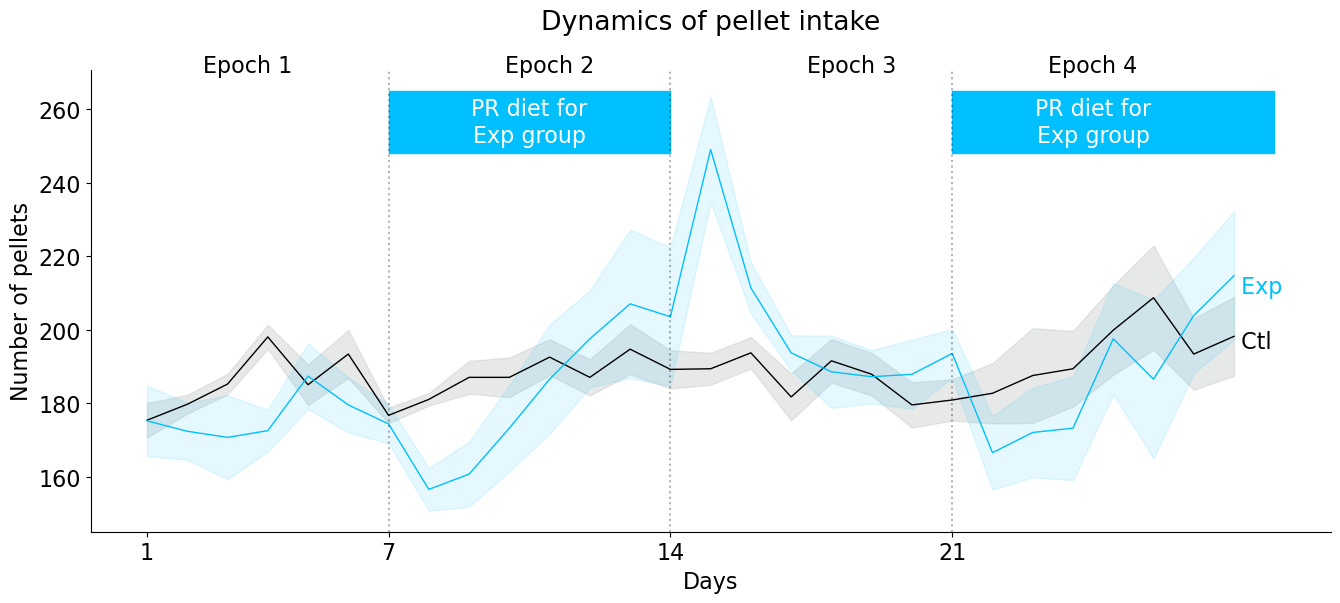

In [21]:
def pellets_by_day(df,maxdays=30):
    return (df
            .rename(index="n_pellets")
            .resample("d", offset = "7H")
            .count()
            .head(maxdays)#We need to add the final two rows instead of deleting last row 
            #.reset_index()
            
           )
ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(pellets_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(pellets_by_day(val["pellets"]))  
        

def clean_df(lst):
    return (pd.concat(lst, axis= 1)
           .fillna(0)
            .reset_index()
            .iloc[:,1:]
           .head(29)) #21 days used because in epoch 4 we used expired pellets for ctl animals and data is excluded, more over the first 2 days of training not covered by the code

ctl_pellets= clean_df(ctl)
exp_pellets= clean_df(exp)

#######plotting the trend of pellet intake in the first 3 weeks in Ctl and Exp mice########################################


f, ax = plt.subplots(figsize=(16,6), ncols=1)
                            # sharey=False,
                            # gridspec_kw={"width_ratios":[0.7,0.3],
                            #              "right":0.9, 
                            #             "wspace":0.4})
                            
tp.shadedError(ax,transposed_ctl,linecolor=ctl_color)
tp.shadedError(ax,transposed_exp,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)


######################################################################################
ax.set_ylabel("Number of pellets")
ax.set_xlabel("Days")
ax.axvline(6,color="k",linestyle=":", alpha= 0.3)
ax.axvline(13,color="k",linestyle=":", alpha= 0.3)
ax.axvline(20,color="k",linestyle=":", alpha= 0.3)
ax.set_xticks([0,6,13,20],labels=["1","7","14","21"])
ax.text(2.5,270,"Epoch 1", ha="center")
ax.text(10,270,"Epoch 2", ha="center")
ax.text(17.5,270,"Epoch 3", ha="center")
ax.text(23.5,270,"Epoch 4", ha="center")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


#adding a highlight bar at the top of EPOCH 2
ax.fill_betweenx([248,265],[6], [13], color = "deepskyblue")
ax.text(9.5,263.2,"PR diet for\nExp group", color="white",va="top", ha="center")

ax.fill_betweenx([248,265],[20], [28], color = "deepskyblue")
ax.text(23.5,263.2,"PR diet for\nExp group", color="white",va="top", ha="center")
# x=np.arange(6,14)
# y=exp_pellets.iloc[6:14,:].T.mean(axis=0)
# ax.plot(x, y,
#          linewidth=3,
#          color=exp_color,
#          linestyle=":")


# fed_cols = [ctl_color,exp_color]
# Ctl_patch = mpatches.Patch(color=fed_cols[0], label='Control')
# Exp_patch = mpatches.Patch(color=fed_cols[1], label='Experimental')
# ax.legend(handles=[Ctl_patch, Exp_patch],
#              bbox_to_anchor=(0.67,0.88),
#              bbox_transform=f.transFigure)
####################################################################################
ctl_E1=ctl_pellets.iloc[0:7,:].mean(axis=0)
ctl_E2=ctl_pellets.iloc[7:14,:].mean(axis=0)
ctl_E3=ctl_pellets.iloc[14:,:].mean(axis=0)
# ctl_E4=ctl_pellets.iloc[14:26,:].mean(axis=0)
exp_E1=exp_pellets.iloc[0:7,:].mean(axis=0)
exp_E2=exp_pellets.iloc[7:14,:].mean(axis=0)
exp_E3=exp_pellets.iloc[14:,:].mean(axis=0)
# exp_E4=exp_pellets.iloc[14:26,:].mean(axis=0)

##################################################################################



ax.set_title("Dynamics of pellet intake", y=1.07)


ax.annotate(" Ctl",[27,195])
ax.annotate(" Exp",[27,210], color= exp_color)


f.savefig(fig_folder + "trend_pellet_delivery_4epoch.png")
##